In [1]:
# import numpy as np
import matplotlib.pyplot as plt

import glob
from pathlib import Path
import json

from livecell_tracker.core.datasets import LiveCellImageDataset, SingleImageDataset
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)

from livecell_tracker.trajectory.contour_utils import get_cellTool_contour_points, viz_contours, get_morphology_PCA
from livecell_tracker.trajectory.contour.cell_contour import align_contours
from livecell_tracker.trajectory.feature_extractors import get_sctc_skimage_features_pca




In [2]:
# importing and creating datasets
dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path(
    "../datasets/test_data_STAV-A549/mask_data"
)

dataset_dir_path_vim = Path(
    "../datasets/test_data_STAV-A549/TRITC_data"
)

time2url_tritc = sorted(glob.glob(str((Path(dataset_dir_path_vim) / Path("*_TRITC.tif")))))
time2url_tritc = {i: path for i, path in enumerate(time2url_tritc)}
vim_dataset = LiveCellImageDataset(time2url=time2url_tritc, ext="tif")

mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")

time2url_dic = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
time2url_dic = {i: path for i, path in enumerate(time2url_dic)}
dic_dataset = LiveCellImageDataset(time2url=time2url_dic, ext="tif")

40 png img file paths loaded;


In [3]:
# convert label masks to single objects
from livecell_tracker.segment.utils import prep_scs_from_mask_dataset
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

100%|██████████| 40/40 [00:11<00:00,  3.44it/s]


In [4]:
# tracking/reading from a previously tracked file

### User defined Quantities ###
max_age_value = 1
min_hits_value = 3
### ----------------------- ###

from typing import List
from livecell_tracker.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)

try:
    traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=max_age_value, min_hits=min_hits_value)
except:
    traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=max_age_value, min_hits=min_hits_value)

### storing the trajectory to json ###
traj_collection.write_json("./notebook_results/general_tutorial/traj_json/traj_collection_40_img.json")

### reading trajectory from json ###
# traj_collection_json_path = "../datasets/test_data/traj_analysis/track_singleCellTrajectoryCollection.json"
# traj_collection_json = json.load(open(traj_collection_json_path, "r"))
# traj_collection = SingleCellTrajectoryCollection().load_from_json_dict(traj_collection_json)

matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T252_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T253_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T254_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T255_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T256_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T257_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21_T258_XY01_DIC.tif
matching image path: ../datasets/test_data_STAV-A549/DIC_data/STAV-A549_VIM_

<Axes: xlabel='Trajectory Length', ylabel='count'>

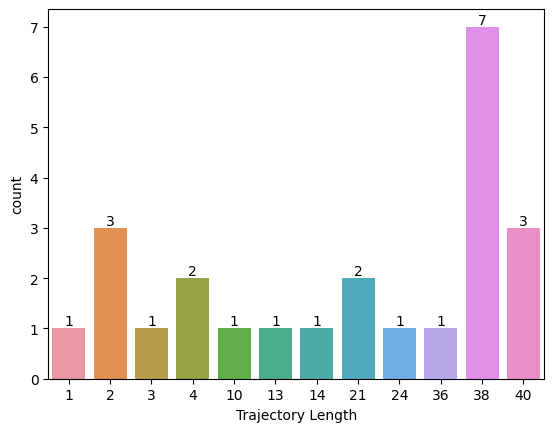

In [11]:
traj_collection.histogram_traj_length()

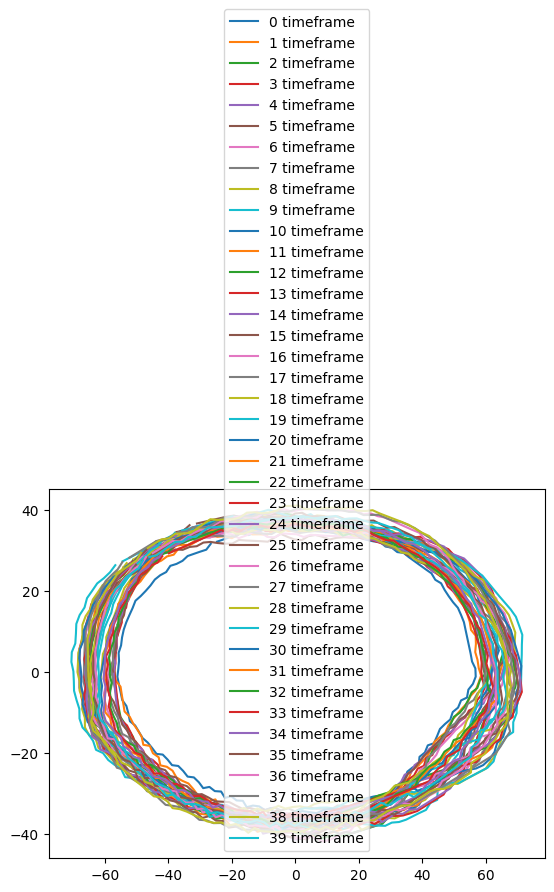

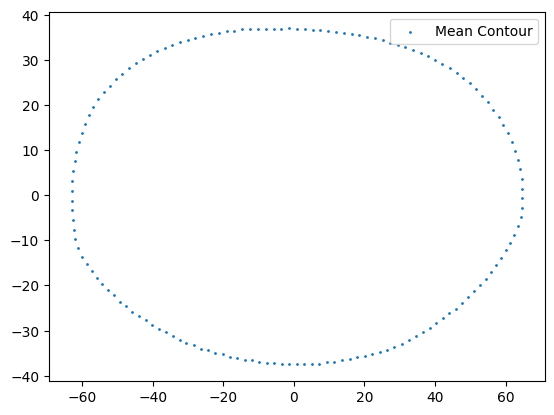

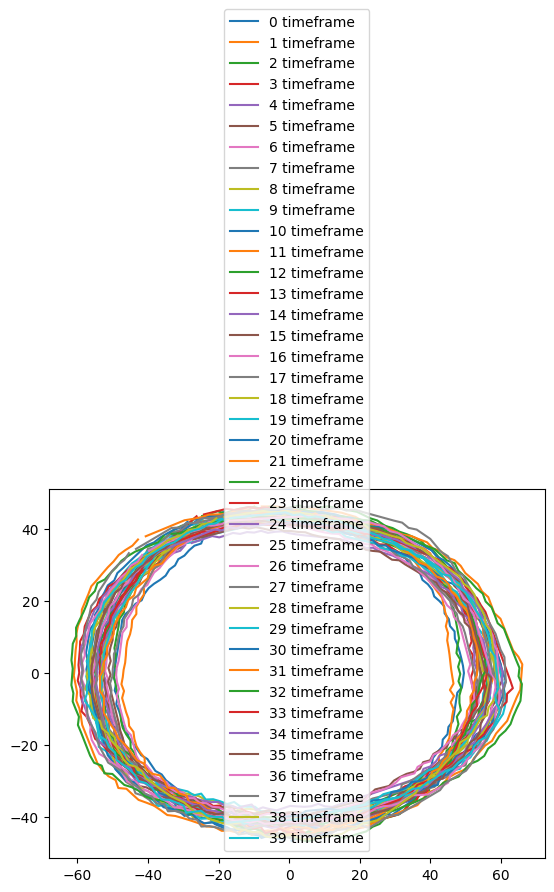

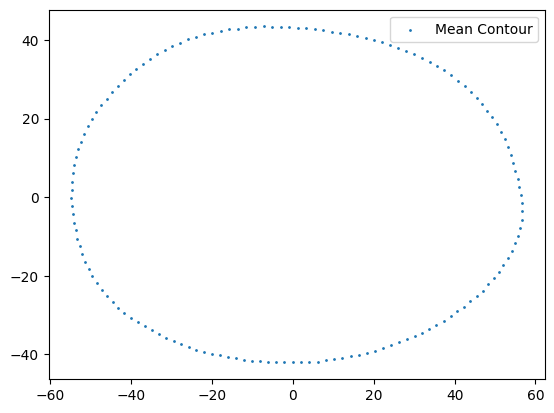

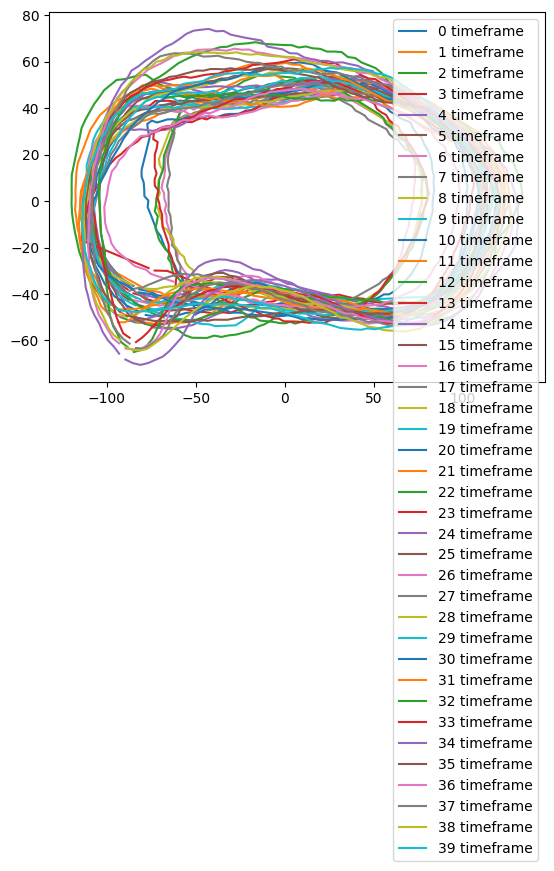

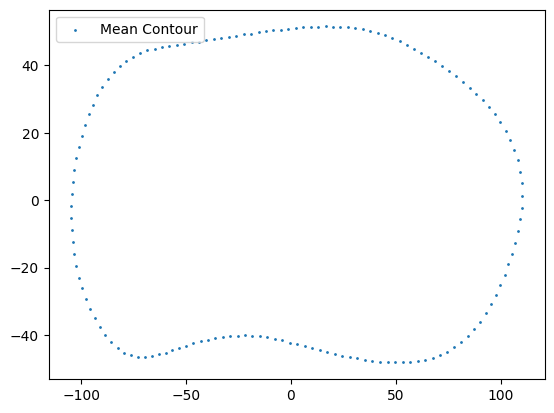

In [15]:
# calculating contour features and pca

# visualizing the contour

### user defined quantities: ###
contour_num_points = 150
traj_len_threshold = 39
### -------------------------------- ###

for track_id_num in traj_collection.get_track_ids():
    traj = traj_collection.get_trajectory(track_id_num)

    
    if len(traj) > traj_len_threshold:
        # getting cell contours using active shape model
        cell_contours = get_cellTool_contour_points(traj, contour_num_points=contour_num_points)
        
        legend_labels = []
        for idx, contour in enumerate(cell_contours):
            plt.plot(contour.points[:, 0], contour.points[:, 1])
            legend_labels.append(str(idx)+" timeframe")
        plt.legend(legend_labels)
        plt.show()
    
        mean_contour, iters = align_contours(cell_contours, allow_reflection=True, allow_scaling=False, max_iters=20)
        plt.scatter(mean_contour.points[:, 0], mean_contour.points[:, 1], s=1)
        plt.legend(["Mean Contour"])
        plt.show()


In [16]:
# calculating contour features and pca

# calculating pca

### user defined quantities: ###
contour_num_points = 150
traj_len_threshold = 39
### -------------------------------- ###

pca_morph = get_morphology_PCA(traj_collection, contour_num_points, traj_len_threshold)

Variance ratios and their sum =  [0.94750349 0.04101257] 0.9885160612284991


In [6]:
# calculating contour features and pca

# calculating pca

### user defined quantities: ###
traj_len_threshold = 39
### -------------------------------- ###

pca_skimage_sctc = get_sctc_skimage_features_pca(traj_collection, vim_dataset, dic_dataset, traj_len_threshold)